# Topic Modelling

Un algorithme de topic modelling est un modèle mathématique/statistique utilisé pour déduire quels sont les sujets qui représentent le mieux les données.

Il est basée sur les hypothèses suivantes :
- Un texte (document) est composé de plusieurs sujets.
- Un sujet est composé d'une collection de mots

Le but de l'algorithme est de calculer une *note* de participation à un thème donné pour chaque mot d'un texte, et pour y parvenr nous allons suivre les étapes ci-dessous:

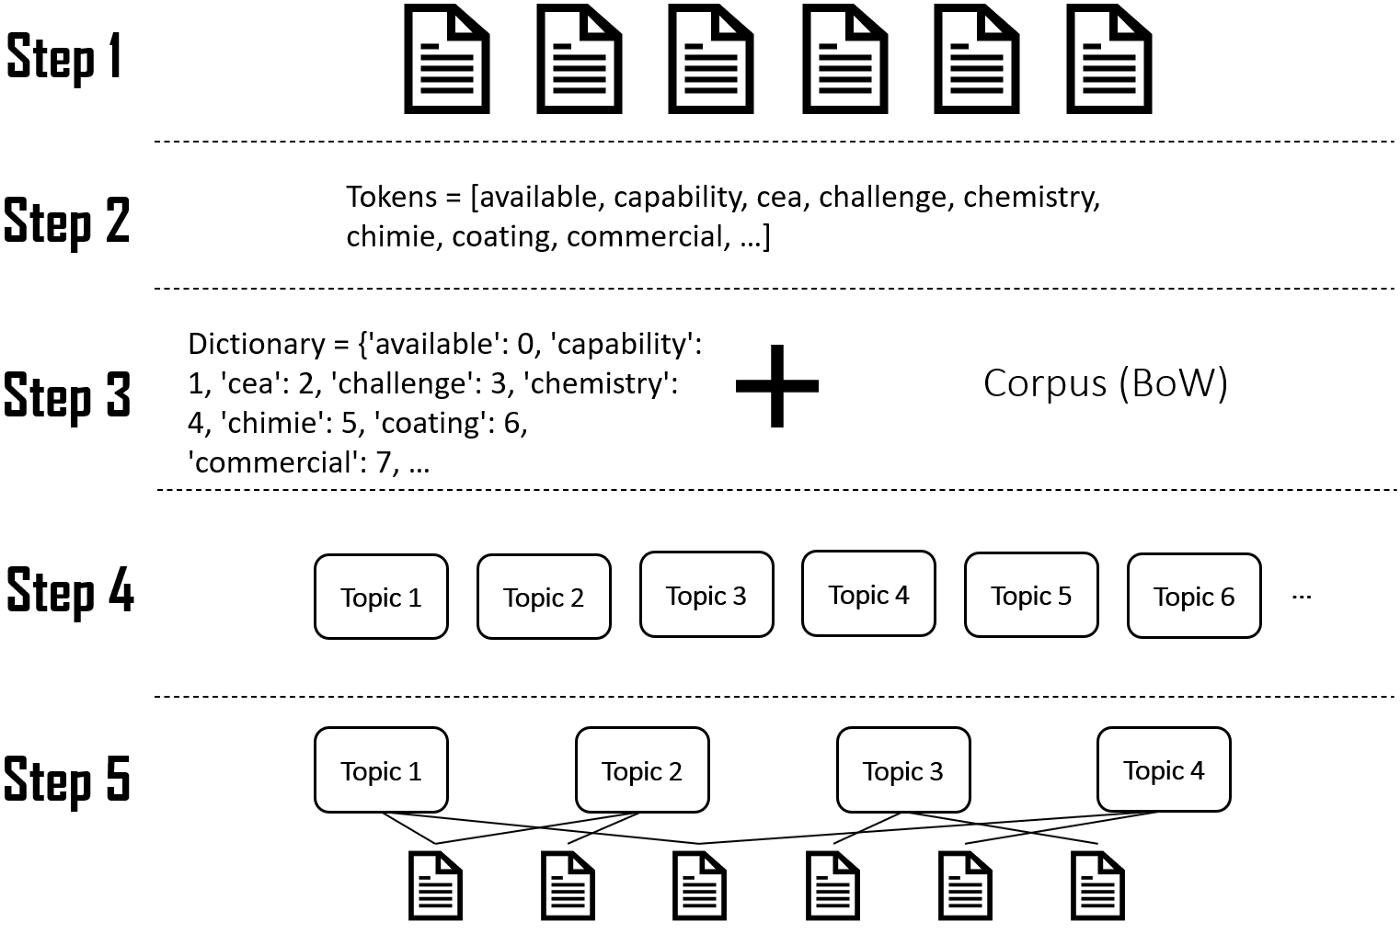

- **Step1** : consiste à *récupèrer les données* et à *conduire une Analyse Exploratoire des données*.
- **Step2** : consiste à *tokeniser* les textes *(c'est à dire découper les phrases mot à mot)*.
- **Step3** : consiste à *créer un dictionnaire associant chaque mot à un ID unique* puis à *créer un Bag Of Words* représentant la fréquence des tokens. 
- **Step4** : consiste à *construire un modèle permettant d'identifier les sujets* puis à l'ajuster *trouver le nombre optimal de sujets*.
- **Step5** : consiste à *utiliser le modèle crée* pour connaitre la distribution des sujets identifiés dans les *(potentiellement nouveaux)* documents.

In [1]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import spacy
import spacy_fastlang
from collections import Counter
from pprint import pprint

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning) 

random_seed = 0
np.random.seed(random_seed)

In [2]:
def get_num_lines(path):
    with open(path) as f:
        for i, _ in enumerate(f):
            pass
    return i+1

In [3]:
def plot_bars(data_, title, labels_modulo=1, labels_rotation=90, show_values=True, show_percent=False, x_label=None, y_label=None, **args):
    
    if show_percent:
        total = data_.values.sum()
        data_ = round(data_/total*100.0,2)

    fig = plt.figure(figsize=(15, 4))
    
    ax = sns.barplot(data=data_, **args)
    
    if show_values:
        ax.bar_label(ax.containers[0])
        
    new_ticks = [i.get_text() for i in ax.get_xticklabels()]
    plt.xticks(range(0, len(new_ticks), labels_modulo), new_ticks[::labels_modulo], rotation=labels_rotation)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(title)
    plt.show()

## Explorons le dataset des `Business`

In [4]:
file_path = os.path.join("data", "yelp_dataset", "yelp_academic_dataset_business.json")
data_business = pd.read_json(file_path, lines=True)  # 150346 x 14
display(data_business.head(2), data_business.shape)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."


(150346, 14)

In [5]:
data_business.categories.value_counts()

Beauty & Spas, Nail Salons                                                                                       1012
Restaurants, Pizza                                                                                                935
Nail Salons, Beauty & Spas                                                                                        934
Pizza, Restaurants                                                                                                823
Restaurants, Mexican                                                                                              728
                                                                                                                 ... 
Dermatologists, Health & Medical, Cosmetic Surgeons, Doctors, Acne Treatment, Skin Care, Beauty & Spas              1
Home Services, Home & Garden, Nurseries & Gardening, Hardware Stores, Shopping, Building Supplies, Appliances       1
Food Trucks, Smokehouse, Restaurants, Food, Barbeque, So

In [6]:
data_business.categories.str.contains('Restaurant').value_counts(dropna=False)

False    97957
True     52286
None       103
Name: categories, dtype: int64

In [7]:
data_restaurant = data_business[data_business.categories.str.contains("Restaurant") == True]
display(data_restaurant.head(2), data_restaurant.shape)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '..."


(52286, 14)

## Explorons le dataset des `Reviews`

In [8]:
file_path = os.path.join("data", "yelp_dataset", "yelp_academic_dataset_review.json")
data_review = pd.read_json(file_path, lines=True, nrows=1000000)  # 6990280 x 9
display(data_review.head(2), data_review.shape)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18


(1000000, 9)

In [9]:
(get_num_lines(file_path), data_review.shape[1])

(6990280, 9)

### Supprimons les reviews qui ne concernent pas des restaurants

In [10]:
join_restaurant_reviews = data_review.merge(data_restaurant, on='business_id', how='left')

In [11]:
join_restaurant_reviews.categories.value_counts(dropna=False)

NaN                                                                                                                                   310481
Restaurants, Mexican                                                                                                                    7915
Mexican, Restaurants                                                                                                                    6219
Restaurants, Pizza                                                                                                                      4760
German, Restaurants, Seafood, Cocktail Bars, French, Brasseries, American (New), Nightlife, Bars, Cajun/Creole, Breakfast & Brunch      4661
                                                                                                                                       ...  
Pakistani, Restaurants                                                                                                                     1
Imported Food

In [12]:
data_review_restos = join_restaurant_reviews[['stars_x', 'text']][join_restaurant_reviews.categories.notnull()]
data_review_restos.rename(columns={'stars_x':'stars'}, inplace=True)
display(data_review_restos.head(2), data_review_restos.shape)

,stars,text
0,3,"If you decide to eat here, just be aware it is..."
2,3,Family diner. Had the buffet. Eclectic assortm...


(689519, 2)

### Regardons plus en détails les variables du jeu de données

#### Les variables qualitatives

In [13]:
data_review_restos.describe(exclude=['number','datetime']).T

,count,unique,top,freq
text,689519,688358,I have eaten at just about every decent Indian...,5


#### Les variables quantitatives

In [14]:
data_review_restos.describe(datetime_is_numeric=True).T

,count,mean,std,min,25%,50%,75%,max
stars,689519.0,3.801433,1.368557,1.0,3.0,4.0,5.0,5.0


## Répartition de la taille des reviews

In [15]:
data_tmp = data_review_restos.copy()
data_tmp['review_size'] = data_review_restos.text.apply(lambda x: len(x.split()))

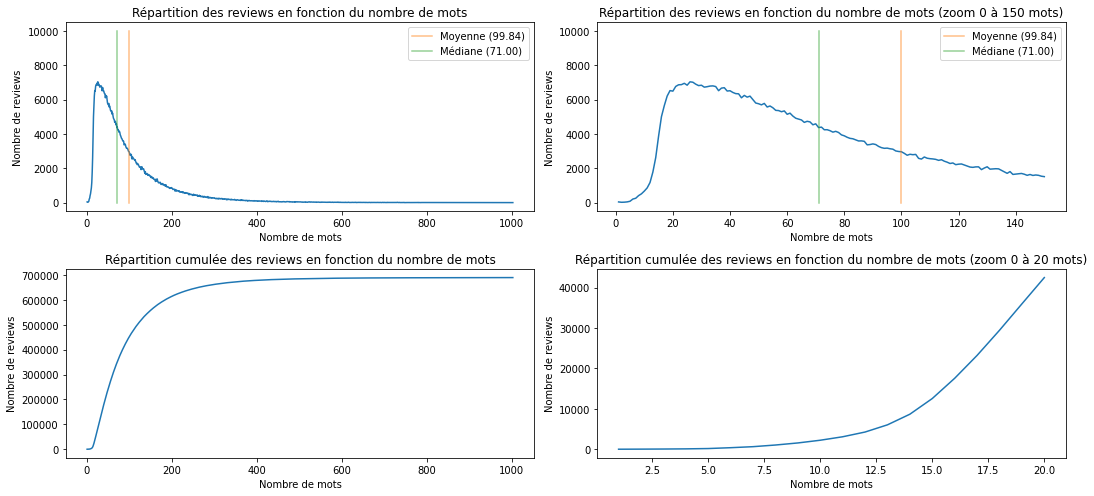

In [16]:
select = pd.DataFrame(data_tmp.review_size.value_counts()).reset_index()
select.sort_values(by='index', inplace=True)
select.set_index('index', inplace=True)

review_size_mean = data_tmp.review_size.mean()
review_size_median = data_tmp.review_size.median()

fig = plt.figure(figsize=(15, 7))
plt.subplot(2,2,1)
sns.lineplot(data=select, y='review_size', x='index')
plt.plot([review_size_mean,review_size_mean],[0,10000], label=f"Moyenne ({review_size_mean:.2f})", alpha=0.5)
plt.plot([review_size_median,review_size_median],[0,10000], label=f"Médiane ({review_size_median:.2f})", alpha=0.5)
plt.title("Répartition des reviews en fonction du nombre de mots")
plt.xlabel("Nombre de mots")
plt.ylabel("Nombre de reviews")
#plt.ylim(0,10000)
plt.legend()

plt.subplot(2,2,2)
zoom_left, zoom_right = 0, 150
sns.lineplot(data=select[zoom_left:zoom_right], y='review_size', x='index')
plt.plot([review_size_mean,review_size_mean],[0,10000], label=f"Moyenne ({review_size_mean:.2f})", alpha=0.5)
plt.plot([review_size_median,review_size_median],[0,10000], label=f"Médiane ({review_size_median:.2f})", alpha=0.5)
plt.title(f"Répartition des reviews en fonction du nombre de mots (zoom {zoom_left} à {zoom_right} mots)")
plt.xlabel("Nombre de mots")
plt.ylabel("Nombre de reviews")
#plt.ylim(0,10000)
plt.legend()

select2 = np.cumsum(select)

plt.subplot(2,2,3)
sns.lineplot(data=select2, y='review_size', x='index')
#plt.plot([xxx,xxx],[0,10000], label="Moyenne", alpha=0.5)
plt.title("Répartition cumulée des reviews en fonction du nombre de mots")
plt.xlabel("Nombre de mots")
plt.ylabel("Nombre de reviews")

plt.subplot(2,2,4)
zoom_left, zoom_right = 0, 20
sns.lineplot(data=select2[zoom_left:zoom_right], y='review_size', x='index')
plt.title(f"Répartition cumulée des reviews en fonction du nombre de mots (zoom {zoom_left} à {zoom_right} mots)")
plt.xlabel("Nombre de mots")
plt.ylabel("Nombre de reviews")

plt.tight_layout()
plt.show()

In [17]:
data_tmp.review_size.describe()

count    689519.000000
mean         99.842822
std          92.353295
min           1.000000
25%          40.000000
50%          71.000000
75%         128.000000
max        1003.000000
Name: review_size, dtype: float64

In [18]:
data_tmp[ data_tmp.review_size < 10 ].shape

(1589, 3)

>#### On constate que :
> - la moitié des reviews ont moins de 75 "mots"
> - 48 des 1.000.000 de reviews ont 1 "mot"...
> - 275 des 1.000.000 de reviews ont 5 "mots" ou moins.
> - environ 800.000 des 1.000.000 de reviews ont moins de 150 "mots"

### Explorons un peu les textes qui n'ont été découpés qu'en un seul "mot"

In [19]:
print(data_tmp.text[ data_tmp.review_size == 1 ][:20])

27539                                                   Boo
67931     意餐，营业到晚上10点，mix的加州红酒很好，这里有意大利和加州的葡萄酒，牛排稍微过熟了，人...
69333                                               Awesome
142373    太美味！连续吃了两个晚上，是在美国少有的鲜美，而环境又非常不错。昨天的担担面、香菇青菜都很好...
144918                                           C'mon!!!!!
183565                                                  Lll
184566                                                  Wow
259830    招牌沙拉就是生菜叶拌咸味沙拉酱，星期四特供的炒饭就是剩饭炒饭，绿洋葱香肠的味道实在不敢恭维，...
265618                                                    .
267429    ダウンタウンの外れにある静かなレストラン。ディナーを食べに行ったが、オシャレな空間の割に静か...
352724                                                 Booo
423441    http://keepbusylife.blogspot.com/2015/03/chees...
442880    点了三杯鸡，酸菜汤，滑蛋虾仁，卤肉饭。都比较一般。达不到惊喜，一般都比较困难，可能还达不到一...
454874    服務唔錯啦，但係嘢食其實冇expect咁好食，點咗牛肉烏東同埋芝士咖喱牛肉烏冬，牛肉新鮮嘅程...
458605    村里新开的川菜馆，味道很好，和国内比都毫不逊色，我最爱他家的烤鱼、哑巴兔和冒菜，适合喜欢吃辣...
468655                                                 Nice
472524    我每次來費城都是為了辦展，這裡的展館對華人來講很方便，旁邊就

>#### On constate que:
> - il y a de nombreux textes qui ne sont pas en Anglais...
> - il y a des url seules
> - il y a des smileys seuls
> - il y a des mots seuls

---
>#### `TODO`  done ✅ | todo ❌ |
> - ✅ Il faut faire en sorte de ne garder que les textes en Anglais.
<br><u>*(action: fait juste après la tokenization)*</u>
> - ❌ Il faut supprimer les entrées avec des URL seules.
> - ✅ Il faut supprimer les reviews d'un seul mot *(elles ne sont que 48 sur 1 millions si l'on compte les langues asiatiques mal splittées)*.
<br><u>*(action: fait ci-dessous)*</u>

In [20]:
data_clean = data_tmp[ data_tmp.review_size > 1 ][['stars','text']]
display(data_clean.head(2), data_clean.shape)

,stars,text
0,3,"If you decide to eat here, just be aware it is..."
2,3,Family diner. Had the buffet. Eclectic assortm...


(689479, 2)

## Répartition des notes *(stars)* des reviews

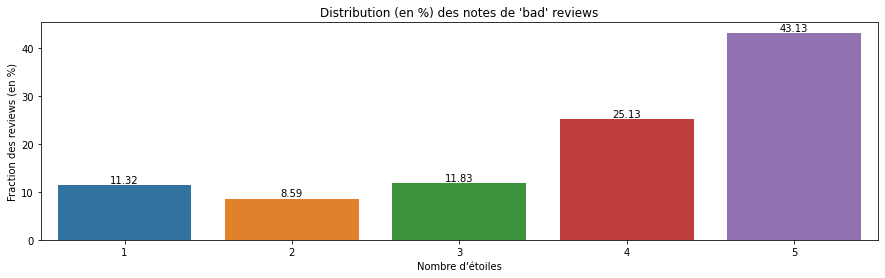

In [21]:
select = pd.DataFrame(data_clean.stars.value_counts()).reset_index()
select.sort_values(by='index', inplace=True)
select.set_index('index', inplace=True)

plot_bars(select.T, "Distribution (en %) des notes de 'bad' reviews", y_label="Fraction des reviews (en %)", x_label="Nombre d'étoiles", labels_rotation=0, show_percent=True)

>#### Nous constatons que la majorité des clients semblent satisfaits.
> Mais dans le cadre de notre projets nous voulons surtout identifier *les sujets qui préoccupent les personnes ayant laissé une mauvaise note*.<br>
> Nous allons donc travailler sur un échantillon de reviews dont les notes sont de 1 ou 2.

#### Binarisation du jeu de données

In [22]:
data_clean['is_low'] = data_clean.stars <= 2 # TRUE with 1,2 stars and FALSE with 3,4,5 stars
display(data_clean.head(2), data_clean.shape)

,stars,text,is_low
0,3,"If you decide to eat here, just be aware it is...",False
2,3,Family diner. Had the buffet. Eclectic assortm...,False


(689479, 3)

In [23]:
data_clean[data_clean.is_low].shape

(137303, 3)

>#### On a donc environ 216k "mauvaises" reviews à utiliser *(en aillant limité le nombre initial de reviews chargées à 1000k)*

#### Sélection au hasard des "mauvaises" reviews *(en conservant le ratio initial des notes)*

In [24]:
sample_size = 10000

In [25]:
# Select samples with the original dataset stars' ratio
data_bad_reviews = data_clean[data_clean.is_low == True].sample(sample_size, random_state=random_seed)[['stars', 'text']].reset_index(drop=True)
display(data_bad_reviews.head(2), data_bad_reviews.shape)

,stars,text
0,2,I've been wanting to try this place for awhile...
1,1,The service here is very very poor. \n\nI don...


(10000, 2)

#### Affichage de la distribution des scores dans le nouveau dataset

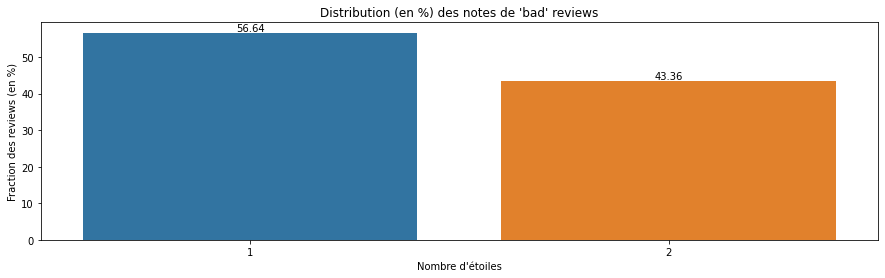

In [26]:
select = pd.DataFrame(data_bad_reviews.stars.value_counts()).reset_index()
select.sort_values(by='index', inplace=True)
select.set_index('index', inplace=True)

plot_bars(select.T, "Distribution (en %) des notes de 'bad' reviews", y_label="Fraction des reviews (en %)", x_label="Nombre d'étoiles", labels_rotation=0, show_percent=True)

## Prétraitement des données

Nous allons utiliser pour préparer les données à l'analyse, une bibliothèque open-source appelée [spaCy](http://spacy.io), mais d'autres bibliothèques telles que [NLTK](https://www.nltk.org) peuvent également être utilisées.

Au cours du processus de Tokenisation, *spaCy* va ajouter plusieurs informations au document, que nous pourrons utiliser ultérieurement *(comme le type de mot, sont lemme, etc.)*

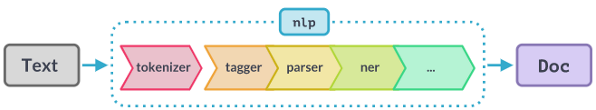

#### Visualisons le jeu de données avant la tokenisation

In [27]:
from wordcloud import WordCloud

In [28]:
from PIL import Image

In [29]:
def plot_wordcloud(text, from_frequency=False):
    alice_mask = np.array(Image.open("Documents/plate_shape.jpg"))
    
    # Create the wordcloud object (the size depends on the mask...)
    wordcloud = WordCloud(background_color="white", width=1000, height=700, margin=2, collocations=False, random_state=random_seed, mask=alice_mask)
    if from_frequency:
        wordcloud = wordcloud.generate_from_frequencies(text)
    else:
        wordcloud = wordcloud.generate(text)

    # Display the generated image:
    fig = plt.figure(figsize=(15, 10.5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()

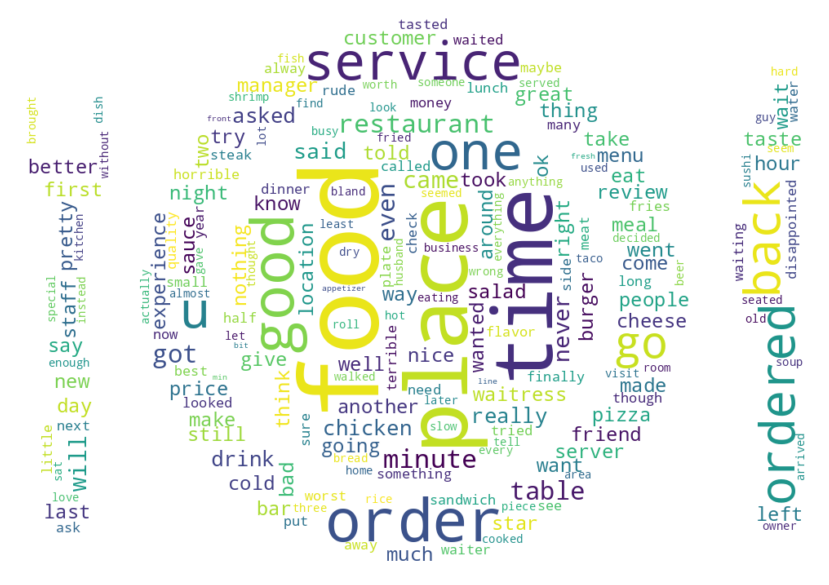

In [30]:
plot_wordcloud(" ".join([x for x in data_bad_reviews.text]))

### Tokenization
>#### Nous allons profiter de cette étape de tokenisation pour supprimer:
> - les majuscules,
> - ~~les espaces en début et fin de texte.~~
> - tout ce qui n'est pas détecté comme étant de l'anglais,
> - la ponctuation,
> - les stop-words,
> - les espaces,
> - les chiffres,
> - les ADVerbes.
>
>#### Par ailleurs on va utiliser les **lemmes** *(raçines contextualisées)* des mots pour rassembler ceux qui sont assez similaires.

In [31]:
!python -m spacy download en_core_web_sm -qq
#!python -m spacy download en_core_web_md -qq
nlp = spacy.load('en_core_web_sm')

2022-06-27 00:48:14.816103: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-27 00:48:14.816130: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [32]:
nlp.add_pipe("language_detector")

In [33]:
def tokenize(text):

    # suppression des majuscules
    text = text.lower()

    # suppression des espaces au début et à la fin des textes
    text = text.strip()

    # tokenisation
    return nlp(text)

> pos_ tag ist
>
> - `ADJ`: adjective, e.g. big, old, green, incomprehensible, first
> - `ADP`: adposition, e.g. in, to, during
> - `ADV`: adverb, e.g. very, tomorrow, down, where, there
> - `AUX`: auxiliary, e.g. is, has (done), will (do), should (do)
> - `CONJ`: conjunction, e.g. and, or, but
> - `CCONJ`: coordinating conjunction, e.g. and, or, but
> - `DET`: determiner, e.g. a, an, the
> - `INTJ`: interjection, e.g. psst, ouch, bravo, hello
> - `NOUN`: noun, e.g. girl, cat, tree, air, beauty
> - `NUM`: numeral, e.g. 1, 2017, one, seventy-seven, IV, MMXIV
> - `PART`: particle, e.g. ’s, not,
> - `PRON`: pronoun, e.g I, you, he, she, myself, themselves, somebody
> - `PROPN`: proper noun, e.g. Mary, John, London, NATO, HBO
> - `PUNCT`: punctuation, e.g. ., (, ), ?
> - `SCONJ`: subordinating conjunction, e.g. if, while, that
> - `SYM`: symbol, e.g. $, %, §, ©, +, −, ×, ÷, =, :), 😝
> - `VERB`: verb, e.g. run, runs, running, eat, ate, eating
> - `X`: other, e.g. sfpksdpsxmsa
> - `SPACE`: space, e.g. 

In [34]:
def filter_tokens(doc, except_words = []):

    # suppression des majuscules
    # text = text_.lower()

    # suppression des espaces au début et à la fin des textes
    #text = text.strip()

    # tokenisation
    # doc = nlp(text)
    # spacy.displacy.render(doc, style='dep',jupyter=True)
    
    # suppression des stopwords, de la ponctuation, des espaces et des adverbes et de ce qui n'est pas en anglais
    tokens = [token for token in doc 
              if not token.is_stop 
              and doc._.language == 'en'
              and doc._.language_score > 0.7
              #and not token.is_punct
              #and not token.is_space 
              #and not token.is_digit 
              and token.is_alpha
              and token.pos_ not in ['ADV', 'AUX', 'CONJ', 'CCONJ', 'DET', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SPACE'] 
              and token.lemma_ not in except_words
             ]
        
    return tokens

In [35]:
def lemmatize(doc):
    return [token.lemma_ for token in doc]

In [36]:
display(data_bad_reviews.head(2), data_bad_reviews.shape)

,stars,text
0,2,I've been wanting to try this place for awhile...
1,1,The service here is very very poor. \n\nI don...


(10000, 2)

In [37]:
data_bad_reviews['spacy_doc'] = data_bad_reviews.text.apply(tokenize)
data_bad_reviews['tokens'] = data_bad_reviews.spacy_doc
data_bad_reviews['lemmas'] = data_bad_reviews.tokens.apply(lemmatize)

In [38]:
display(data_bad_reviews.head(2), data_bad_reviews.shape)

,stars,text,spacy_doc,tokens,lemmas
0,2,I've been wanting to try this place for awhile...,"(i, 've, been, wanting, to, try, this, place, ...","(i, 've, been, wanting, to, try, this, place, ...","[I, 've, be, want, to, try, this, place, for, ..."
1,1,The service here is very very poor. \n\nI don...,"(the, service, here, is, very, very, poor, ., ...","(the, service, here, is, very, very, poor, ., ...","[the, service, here, be, very, very, poor, ., ..."


(10000, 5)

### Nettoyage des tokens

#### Regardons si il y a des textes dans d'autres langues ou dans de l'anglais approximatif

In [39]:
for doc in data_bad_reviews.spacy_doc:
    # is in english
    if doc._.language != 'en':
        print("NOT ENGLISH:\n", doc, "\n", "-"*50)
    elif doc._.language_score <= 0.7:
        print(f"GIBBERISH:{doc._.language_score}\n", doc, "\n", "-"*50)

NOT ENGLISH:
 si tienes alguna situacion y tienes que hablar con el dueño e aseguro que te va a tratar mal . 
 --------------------------------------------------
GIBBERISH:0.6311492919921875
 horrible ! the wait is way to long & the food is not even that good , oh & its way to expensive . muy mal servicio ! 
 --------------------------------------------------
NOT ENGLISH:
 i ordered a cuban sandwich, what  a disaster! let me start off by saying the lady behind the counter preheated the lunch meat in the microwave. then when i asked for pickles she took a mountain of pickles and slapped my sandwich together with my microwaved lunch meat!  i will never be back nor will i recommend anyone to eat there. terrible!!! this location gives cuban people and food a bad reputation. 

pedí un sandwich cubano, ¡qué desastre! déjame empezar diciendo que la señora detrás del mostrador precalentó la carne del almuerzo en el microondas. entonces cuando pedí encurtidos tomó una montaña de pepinillos y me

>#### On découvre:
> - plusieurs textes en espagnol ou en japonais/chinois
> - un casier judiciaire
> - des textes rédigés en plusieurs langues

#### Appliquons un filtre pour nettoyer ces tokens
- Suppression des langues étrangères *(ce qui n'est pas de l'Anglais)*
- Suppression des stop-words
- Suppression des mots qui ne sont pas composés de lettres de l'alphabet

In [40]:
data_bad_reviews['tokens'] = data_bad_reviews.spacy_doc.apply(filter_tokens)
data_bad_reviews['lemmas'] = data_bad_reviews.tokens.apply(lemmatize)

In [41]:
display(data_bad_reviews.head(2), data_bad_reviews.shape)

,stars,text,spacy_doc,tokens,lemmas
0,2,I've been wanting to try this place for awhile...,"(i, 've, been, wanting, to, try, this, place, ...","[wanting, try, place, awhile, disappointed, se...","[want, try, place, awhile, disappointed, servi..."
1,1,The service here is very very poor. \n\nI don...,"(the, service, here, is, very, very, poor, ., ...","[service, poor, recommend, calamari, server, r...","[service, poor, recommend, calamari, server, r..."


(10000, 5)

#### Visualisons le jeu de données après la tokenisation

In [42]:
def get_all_lemmas(data):
    all_lemmas = []
    for tokens in data:
        all_lemmas.extend(tokens)
    return all_lemmas

all_lemmas = get_all_lemmas(data_bad_reviews.lemmas)

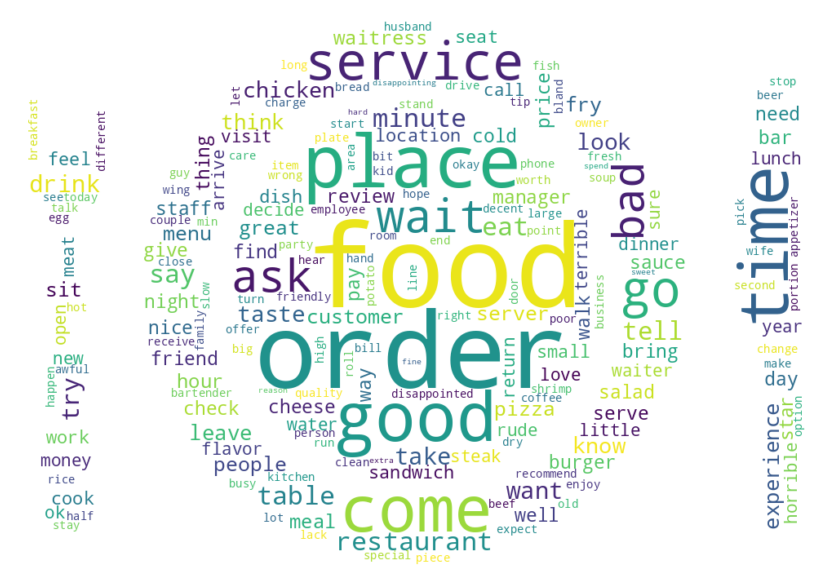

In [43]:
plot_wordcloud(" ".join(all_lemmas))

### Suppression des mots les plus fréquents

In [44]:
lemmas_freq = Counter(all_lemmas)
common_lemmas = lemmas_freq.most_common(100)
print (common_lemmas)

[('food', 9201), ('order', 8471), ('place', 5844), ('good', 5083), ('time', 5046), ('come', 4839), ('service', 4313), ('go', 3970), ('like', 3520), ('get', 3467), ('wait', 3361), ('ask', 3248), ('bad', 3044), ('restaurant', 2986), ('say', 2970), ('minute', 2943), ('eat', 2879), ('table', 2800), ('tell', 2657), ('try', 2550), ('want', 2318), ('drink', 2318), ('take', 2291), ('taste', 2154), ('look', 2090), ('know', 1992), ('chicken', 1950), ('think', 1872), ('leave', 1842), ('experience', 1834), ('people', 1756), ('server', 1738), ('great', 1706), ('pizza', 1678), ('fry', 1667), ('customer', 1645), ('sit', 1627), ('menu', 1590), ('hour', 1553), ('waitress', 1535), ('meal', 1535), ('thing', 1471), ('manager', 1443), ('staff', 1402), ('price', 1400), ('well', 1389), ('sauce', 1385), ('serve', 1373), ('give', 1372), ('bar', 1359), ('review', 1321), ('cheese', 1315), ('walk', 1301), ('star', 1293), ('pay', 1290), ('night', 1267), ('nice', 1249), ('salad', 1220), ('need', 1219), ('check', 11

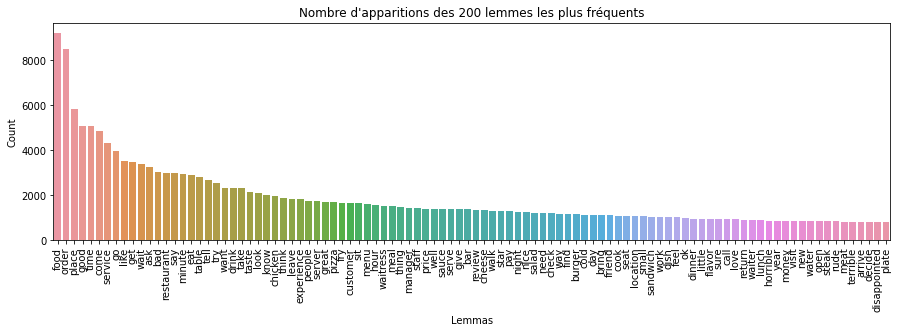

In [45]:
select = pd.DataFrame(common_lemmas[:200], columns=['lemmas','count'])
plot_bars(select, title="Nombre d'apparitions des 200 lemmes les plus fréquents", x='lemmas', y='count', show_values=False, y_label="Count", x_label="Lemmas")

>#### Les mots les plus fréquents sont des mots peu informatifs car présent dans la plupart des textes...
> Par exemple les lemmes `Food` ou `order` font plus de 6000 aparitions sur un jeu de données d'environ 10000 textes.

> On va les supprimer à la création du Dictionnaire

In [46]:
drop_lemmas = [x[0] for x in lemmas_freq.most_common(100)]
#drop_lemmas.extend(['come', 'go', 'tell', 'say', 'get', 'ask', 'want', 'try', 'look', 'take', 'find', 'let', 'guy', 'arrive', 'think'])

#### Visualisons le jeu de données après ce nettoyage plus complet

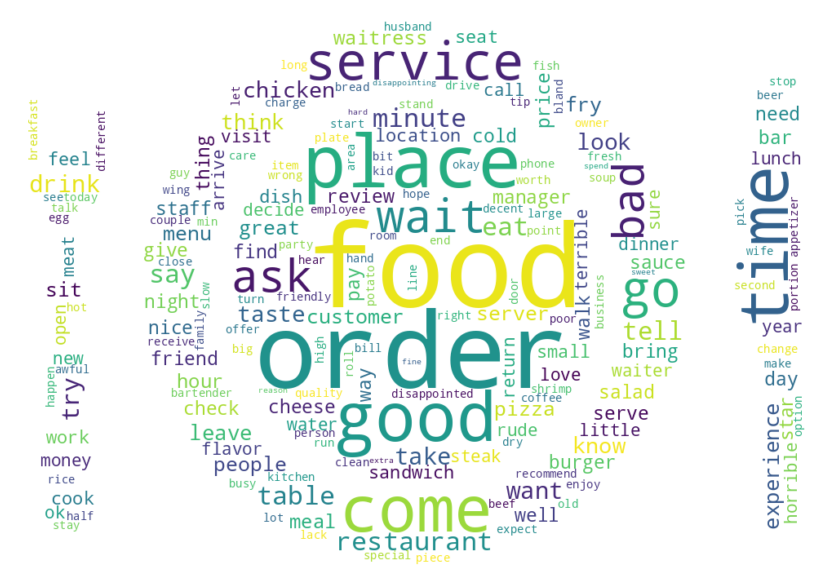

In [47]:
all_lemmas = get_all_lemmas(data_bad_reviews.lemmas)
plot_wordcloud(" ".join(all_lemmas))

### Création du Dictionnaire et du Corpus

Pour les modèles que nous allons essayer, il nous faut un **Dictionnaire** et un **Corpus**.
- Le Dictionnaire permet d'associer un ID unique à chaque token.
- Le Corpus ou Bag Of Word associe ID du dictionnaire à une fréquence.

In [73]:
from gensim.corpora.dictionary import Dictionary

In [74]:
dictionary = Dictionary(data_bad_reviews['lemmas'])

In [75]:
print(str(dictionary.token2id)[:1000], "... }")

{'admit': 0, 'affordable': 1, 'awhile': 2, 'bad': 3, 'chipotle': 4, 'close': 5, 'disappointed': 6, 'employee': 7, 'entire': 8, 'expect': 9, 'feel': 10, 'food': 11, 'friend': 12, 'friendly': 13, 'get': 14, 'good': 15, 'like': 16, 'mouth': 17, 'nice': 18, 'order': 19, 'people': 20, 'place': 21, 'quiet': 22, 'ready': 23, 'restaurant': 24, 'rush': 25, 'salad': 26, 'salty': 27, 'service': 28, 'speak': 29, 'taste': 30, 'time': 31, 'try': 32, 'visit': 33, 'want': 34, 'way': 35, 'well': 36, 'woman': 37, 'ask': 38, 'calamari': 39, 'compe': 40, 'dress': 41, 'eat': 42, 'guess': 43, 'introduce': 44, 'know': 45, 'little': 46, 'manager': 47, 'piece': 48, 'poor': 49, 'portion': 50, 'rave': 51, 'recommend': 52, 'regret': 53, 'return': 54, 'second': 55, 'server': 56, 'shrimp': 57, 'skewer': 58, 'small': 59, 'spend': 60, 'steak': 61, 'street': 62, 'table': 63, 'tasty': 64, 'tiny': 65, 'today': 66, 'wish': 67, 'addition': 68, 'area': 69, 'ashamed': 70, 'ass': 71, 'bareable': 72, 'bleach': 73, 'brown': 74

In [76]:
len(dictionary)

14467

#### Supprimons les mots les plus fréquents et les moins fréquents
- On supprime les mots qui apparaissent dans moins de 5 documents
- On supprime les mots qui apparaissent dans plus de 50% des documents

In [77]:
#dictionary.filter_extremes(no_below=5, no_above=0.25, keep_n=None)
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=None)

In [78]:
len(dictionary)

4527

#### Récupérons la Fréquence de chaque lemme pour afficher à nouveau le WordCloud

In [79]:
dico_df = pd.DataFrame(dictionary.items(), columns=['index', 'key']).set_index('index')

In [80]:
count_df = pd.DataFrame(dictionary.cfs, index=['index', 'count']).T.set_index('index')

In [81]:
TF = count_df.merge(dico_df, on='index', how='left').set_index('key')

In [99]:
TF.drop(np.nan, axis=0, inplace=True)

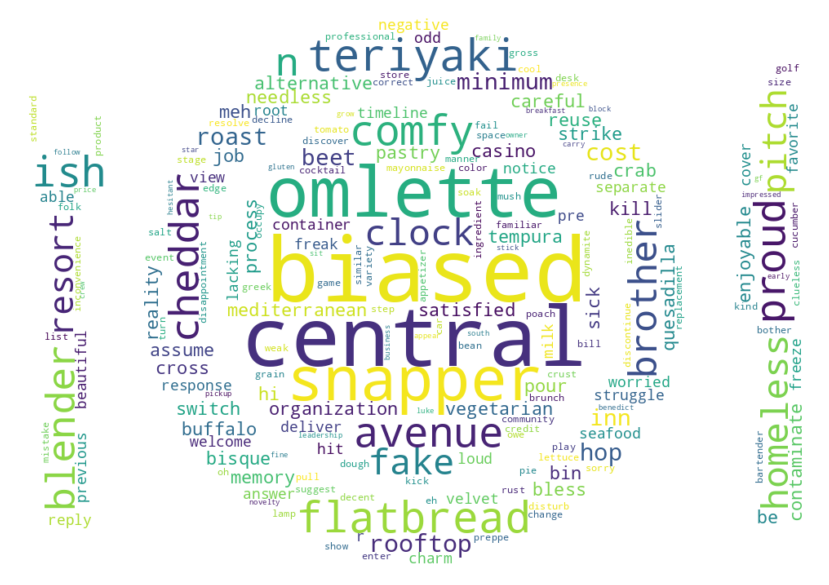

In [102]:
plot_wordcloud(TF.to_dict()['count'], from_frequency=True)

#### Construisons le Corpus *(Bag Of Words)*

In [103]:
corpus = [dictionary.doc2bow(doc) for doc in data_bad_reviews['lemmas']]

## Analyse des topics (LDA ou NMF)
[ ⚠️ pour les commentaires insatisfaits uniquement ! ]

> #### **Latent Dirichlet Allocation** *(LDA)*
> C'est une méthode non-supervisée générative vraiment efficace qui se base sur les hypothèses suivantes :
> - Chaque document du corpus est un ensemble de mots sans ordre (bag-of-words)
> - Chaque document *m* aborde un certain nombre de thèmes dans différentes proportions qui lui sont propres *p(θm)*
> - Chaque mot possède une distribution associée à chaque thème *p(ϕk)*. On peut ainsi représenter chaque thème par une probabilité sur chaque mot.
> - *z_n* représente le thème du mot *w_n*

> #### **Negative Matrix Factorisation** *(NMF)*
> Une autre type de modélisation de sujet automatique non supervisée à décrire et tester.

In [104]:
from gensim.models import LdaMulticore, CoherenceModel

In [105]:
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=10, passes=10, random_state=random_seed)

In [106]:
# import pyLDAvis
# import pyLDAvis.sklearn
import pyLDAvis.gensim_models

/home/valkea/Dev/OpenClassrooms/Projets_AI/P6/venvP6/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [107]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

### Trouvons le nombre idéal de sujets

Les algorithmes de topic modelling reposent sur les mathématiques et les statistiques, mais les sujets mathématiquement optimaux ne sont pas nécessairement "bons" d'un point de vue humain et peuvent être des sujets trompeurs et dénués de sens.

L'évaluation des sujets est donc habituellement complétée par des évaluations humaines telles que la lecture des mots les plus importants de chaque sujet et la visualisation des sujets liés à chaque document *(word-cloud utilisés plus haut)*. Malheureusement, cette tâche exige souvent des connaissances préalables sur le domaine du jeu de données et peut nécessiter l'avis de spécialistes. Et même si l'on dispose d'un tel spécialiste, une telle vérification peut prendre beaucoup de temps et s'avérer impraticable pour de très grands ensembles de données contenant des milliers de sujets.

Il convient donc d'utiliser une métrique capable de vérifier **automatiquement** que les mots groupés ensemble ont bel et bien un thème commun. C'est ce que font les métriques de **mesure de cohérence** des sujets qui tentent de représenter la qualité de la perception humaine des sujets sous la forme d'un nombre unique, objectif et facile à évaluer.

Un point important des mesures de cohérence des sujets est qu'**elles dépendent non seulement du sujet lui-même mais aussi de l'ensemble de données utilisé comme référence**...

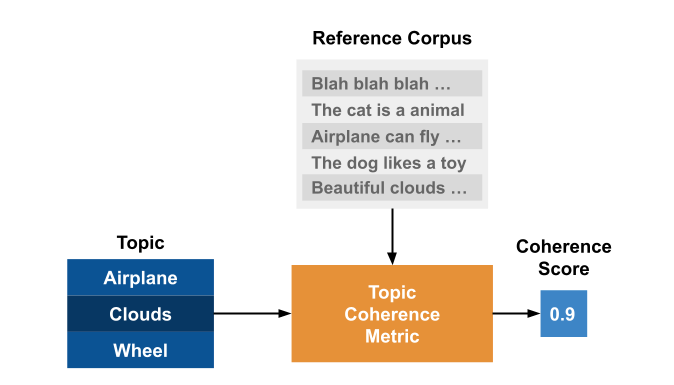

Il existe plusieurs modèles pour calculer un score de coéherence *(C_v, C_p, C_uci, C_umass, C_npmi, C_a, ...)*, mais nous allons utiliser le modèle C_umass car il est souvent recommandé *(mais aussi parcque c'est celui qui m'a donné les résultats les plus rapides lors de mes tests...)*.

#### C_mmass
- la mesure de cohérence retournée par le modèle C_umass est nécessairement négative,
- plus le score est grand et plus la mesure de cohérence indique que le sujet est compréhensible par les humains.


In [108]:
from tqdm import tqdm
# from tqdm.notebook import tqdm

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 17/19 [04:51<00:36, 18.09s/it]/home/valkea/Dev/OpenClassrooms/Projets_AI/P6/venvP6/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/valkea/Dev/OpenClassrooms/Projets_AI/P6/venvP6/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/valkea/Dev/OpenClassrooms/Projets_AI/P6/venvP6/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/ho

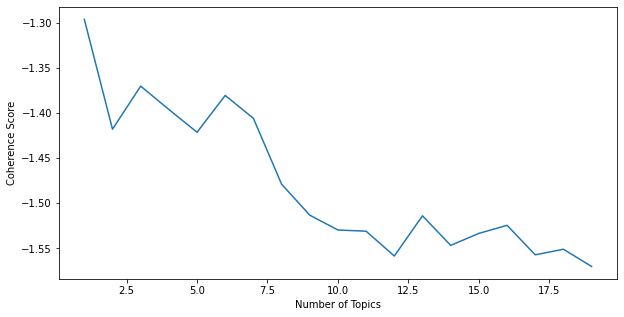

In [109]:
score = []

for i in tqdm(range(1,20,1)):
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, passes=10, random_state=random_seed)
    cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    score.append(cm.get_coherence())
    
plt.figure(figsize=(10, 5))
plt.plot(range(1,20), score)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.show()

>#### On constate que le nombre idéal de sujets est de 1 ou 2... mais comme ça ne présente pas vraiment d'intérêt, nous allons partir sur 3 qui a un score intéressant également.

### Entrainement d'un modèle LDA avec le nombre de topics identifié

In [110]:
num_topics = 3
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=num_topics, passes=100, random_state=random_seed)

In [111]:
lda_model.print_topics(-1)

[(0,
  '0.019*"good" + 0.015*"place" + 0.013*"like" + 0.013*"order" + 0.012*"taste" + 0.010*"chicken" + 0.009*"eat" + 0.008*"fry" + 0.008*"come" + 0.008*"sauce"'),
 (1,
  '0.015*"table" + 0.015*"come" + 0.015*"service" + 0.013*"wait" + 0.012*"time" + 0.012*"ask" + 0.012*"place" + 0.011*"drink" + 0.011*"go" + 0.011*"minute"'),
 (2,
  '0.048*"order" + 0.022*"time" + 0.017*"pizza" + 0.015*"place" + 0.012*"get" + 0.011*"go" + 0.011*"say" + 0.010*"service" + 0.010*"minute" + 0.010*"tell"')]

>### On peut supposer que :
> - le `sujet 1` concerne `le goût / la qualité de la nourriture`.
> - le `sujet 2` concerne `la qualité du service pour de la vente sur place`.
> - le `sujet 3` concerne `la qualité du service pour de la vente à emporter`.

In [135]:
data_bad_reviews['text'][6]

'I order from the natural café Hitchcock location frequently and have never had any issues. I recently ordered form the state street location and had a horrible experience. We called in an order of 2 old town salads(my usual order) to take home. when I stared to eat my salad i got, not just a strand of hair but a clump of hair, as if some one brushed their hair over my salad. I was repulsed and had to call them back about my finding. The girl on the other end of the phone was apologetic and offered to replace it. I agreed to drive back and have them make me a fresh one without the hair. I went to go pick up my new salad and the girl behind the counter had attitude about how it couldn\'t be hair," It must be one of the brushes we use to clean the grill or its a towel" regardless of if its hair or not, don\'t make an excuse and give an attitude to a customer who found something in their food that should not have been there.'

In [136]:
lda_model[corpus][6]

[(1, 0.08541936), (2, 0.9078036)]

In [115]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

In [ ]:
import FreeMobileSMS as sms
sms.send()

---
---
---
---

## Encodage du texte avec TF-IDF 

> #### ⚠️ NOTE:
> - all_corpus --> data_words[:1][0] ??
> - all_lemmas --> data_lemmatized

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True, max_df=0.90)
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(all_corpus)
display(tfidf_vectorizer.get_feature_names_out())
print(tfidf_vectorizer_vectors.shape)

In [ ]:
# get the first vector out (for the first document) 
first_vector_tfidfvectorizer=tfidf_vectorizer_vectors[0] 
# place tf-idf values in a pandas data frame 
df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names_out(), columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False)